# Enoncé

Vous avez participé à une compétition sur Kaggle sur le jeu de données de Titanic (celle-ci existe, les curieux peuvent la retrouver sur Kaggle !). Vous avez pour cela à votre disposition [une liste de 891 passagers](https://www.kaggle.com/c/titanic), contenant les caractéristiques suivantes :


- PassengerID : Identifiant du passager
- Survived : Indicateur de survi d'un passager (1 si le passager a survecu, 0 s’il est décédé)
- Pclass: Classe du passager (1 = 1ère classe, 2 = 2ème classe, 3 = 3ème classe)
- Name : Nom et titre du passager
- Sex : Sexe du passager
- Age : Age du passager (Décimal si inférieur à 1, estimé si de la forme xx.5)
- SibSp : Nombre d’époux, de frères et de soeurs présents à bord
- Parch : Nombre de parents ou d’enfants présents à bord 
- Ticket : Numéro du ticket 
- Fare : Tarif des tickets (Le prix est indiqué en £ et pour un seul achat (peut correspondre à plusieurs tickets)
- Cabin : Numéro de Cabine
- Embarked : Port d’embarcation (C = Cherbourg, Q = Queenstown, S = Southampton)
	 	

# Exercice

La compétition a été l’occasion de revenir sur ce jeu de données très célèbre, et plusieurs tâches étaient attendues, :
- identifier les facteurs favorisants la survie d'un passager par rapport à un autre, en dressant une typologie des survivants
- créer un algorithme qui pourrait prédire la survie d'un individu à partir de ces caractéristiques.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from statistics import mean

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import statsmodels.formula.api as smf

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from mpl_toolkits.mplot3d import Axes3D

from sklearn.pipeline import make_pipeline

from sklearn.svm import SVR

from sklearn.datasets import make_classification 

from sklearn.linear_model import LogisticRegression

In [2]:
df_train = pd.read_csv("train.csv")
df_gender_submission = pd.read_csv("gender_submission.csv")
df_test = pd.read_csv("test.csv")
df_test = df_test.merge(df_gender_submission, how='inner', on='PassengerId')
df = pd.concat([df_train,df_test], ignore_index=True)

In [3]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


<H1>Nettoyage des données

<H2>Cabin

In [5]:
df.Cabin = df.Cabin.fillna("U")

In [6]:
alpha = ["T","A","B","C","D","E","F","G"]
for row in df.index:
    for lettre in alpha:
        if lettre in df.Cabin[row]:
            df.Cabin[row] = lettre

<ipython-input-6-6cd9b6e1bf48>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Cabin[row] = lettre


<b>On remplace les valeurs manquantes de Cabin par "U" pour "Unknow". Ensuite, on supprime les chiffres après la lettre de la cabine. Cela permettra de prendre en compte les "lettres" de cabines dans nos algorythmes après encodage.

<H2>Sex

In [7]:
df.Sex.replace(['male','female'],[0,1],inplace=True)

<b>On convertis les valeurs "male" et "female" en valeurs numériques pour qu'elles soient exploitables par les algorythmes de machine learning.

<H2>Embarked

In [8]:
df[df.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B,NaN


In [9]:
for row in df.index:
    if "B2" in df.Cabin[row]:
        print(df.Cabin[row],df.Embarked[row],df.Ticket[row])

In [10]:
df.Embarked = df.Embarked.fillna("S")

<b> On remarque que les individus ayant des numéros de cabines proche de ceux qui nous interessent ont tous embarqués au port "S". On remplace donc nos deux valeurs manquantes par "S".

<H2>Fare

In [11]:
df[df.Fare.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,0,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,U,S


In [12]:
liste_prix_proches_voisins = []
for row in df.index:
    if df.Cabin[row] == "U" and df.Embarked[row] == "S" and df.Pclass[row] == 3 and 50 < df.Age[row] < 70 and df.Fare[row] > 0 :
        liste_prix_proches_voisins.append(df.Fare[row])

In [13]:
liste_prix_proches_voisins,mean(liste_prix_proches_voisins)

([7.25, 8.05, 8.05, 6.2375, 7.75, 9.5875, 7.0542], 7.711314285714286)

In [14]:
df.Fare = df.Fare.fillna(mean(liste_prix_proches_voisins))

<b>On a identifier les autres passagers avec les mêmes caractéristiques que notre individu avec une valeur manquante. On observe des prix relativements proches donc on remplace la valeur manquante par la moyenne des prix.

<H2>Age

In [15]:
df[df.Age.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",0,NaN,0,0,330877,8.4583,U,Q
17,18,1,2,"Williams, Mr. Charles Eugene",0,NaN,0,0,244373,13.0000,U,S
19,20,1,3,"Masselmani, Mrs. Fatima",1,NaN,0,0,2649,7.2250,U,C
26,27,0,3,"Emir, Mr. Farred Chehab",0,NaN,0,0,2631,7.2250,U,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",1,NaN,0,0,330959,7.8792,U,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
1299,1300,1,3,"Riordan, Miss. Johanna Hannah""""",1,NaN,0,0,334915,7.7208,U,Q
1301,1302,1,3,"Naughton, Miss. Hannah",1,NaN,0,0,365237,7.7500,U,Q
1304,1305,0,3,"Spector, Mr. Woolf",0,NaN,0,0,A.5. 3236,8.0500,U,S
1307,1308,0,3,"Ware, Mr. Frederick",0,NaN,0,0,359309,8.0500,U,S


In [16]:
mask = df["Age"].notnull()
lr = smf.ols(formula="Age ~ Survived + Pclass + Sex + SibSp + Parch + Fare + Embarked + Cabin",
            data=df.loc[mask,:]).fit()
df.loc[~mask,"Age"] = round(lr.predict(df.loc[~mask,:].drop(columns=["Age"])),0)

<b>Le nombre de valeurs manquantes dans la colonne "Age" étant important, on utilise un algorythme de regression linéaire pour remplacer ces valeurs.

<H2>Suppression des colonnes non exploitables

In [17]:
df = df.drop(columns=['PassengerId','Name','Ticket'])

<H2>Verification du nettoyage

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   int64  
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Cabin     1309 non-null   object 
 8   Embarked  1309 non-null   object 
dtypes: float64(2), int64(5), object(2)
memory usage: 92.2+ KB


In [19]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,U,S
1,1,1,1,38.0,1,0,71.2833,C,C
2,1,3,1,26.0,0,0,7.9250,U,S
3,1,1,1,35.0,1,0,53.1000,C,S
4,0,3,0,35.0,0,0,8.0500,U,S
...,...,...,...,...,...,...,...,...,...
1304,0,3,0,28.0,0,0,8.0500,U,S
1305,1,1,1,39.0,0,0,108.9000,C,C
1306,0,3,0,38.5,0,0,7.2500,U,S
1307,0,3,0,28.0,0,0,8.0500,U,S


<b>Il n'y a plus de données manquantes dans le dataframme. Le nettoyage est terminé.

In [20]:
df_save = df.copy()

<H1>Visualisation des données

<ipython-input-21-9c8d9575c9f6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.w_xaxis.set_ticklabels(["","Hommes","","","","","Femmes"])
<ipython-input-21-9c8d9575c9f6>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.w_zaxis.set_ticklabels(["","                     Première Classe","","","","                     Deuxième Classe","","","","                     Troisième Classe"])


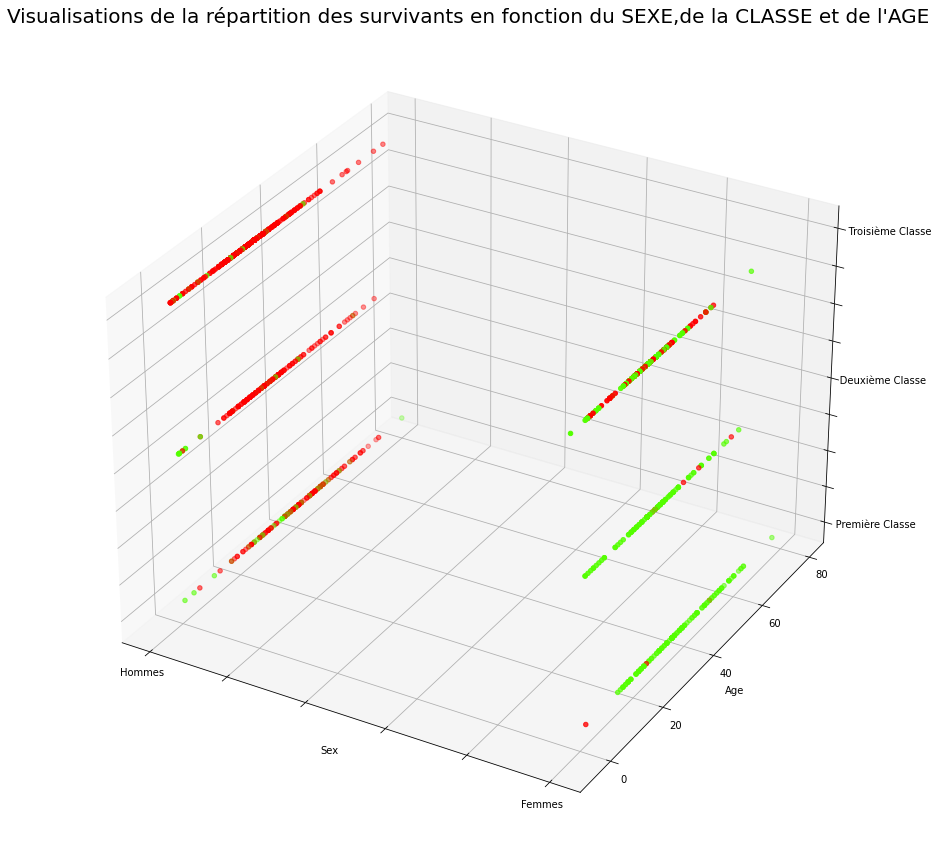

In [21]:
fig = plt.figure(1,figsize=(15, 15))
ax = fig.add_subplot(111, projection = '3d')

x = df['Sex']
y = df['Age']
z = df['Pclass']

ax.set_title("Visualisations de la répartition des survivants en fonction du SEXE,de la CLASSE et de l'AGE",size=20)
ax.set_xlabel('Sex')
ax.w_xaxis.set_ticklabels(["","Hommes","","","","","Femmes"])
ax.set_ylabel('Age')
ax.w_zaxis.set_ticklabels(["","                     Première Classe","","","","                     Deuxième Classe","","","","                     Troisième Classe"])

ax.scatter(x, y, z,c = df["Survived"],cmap=plt.cm.prism)

plt.show()

<b>On remarque que le facteur de survie le plus déterminant est le sexe puis en second la classe.

<H1>Pre-Processing

In [22]:
transformer_cabin = LabelEncoder()
transformer_embarked = LabelEncoder()

In [23]:
df["Cabin"] = transformer_cabin.fit_transform(df["Cabin"])

In [24]:
df["Embarked"] = transformer_embarked.fit_transform(df["Embarked"])

In [25]:
df['Pclass'] = df['Pclass'].astype('category')
df['Sex'] = df['Sex'].astype('category')
df['Cabin'] = df['Cabin'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')
df['Survived'] = df['Survived'].astype('category')

In [26]:
scaler_age = MinMaxScaler()
scaler_fare = MinMaxScaler()

In [27]:
df["Age"] = scaler_age.fit_transform(df["Age"].values.reshape(-1, 1))

In [28]:
df["Fare"] = scaler_fare.fit_transform(df["Fare"].values.reshape(-1, 1))

In [29]:
df["cat_age"] = pd.qcut(df["Age"],5)
df["cat_fare"] = pd.qcut(df["Fare"],5)
df["cat_age"] = df["cat_age"].apply(LabelEncoder().fit_transform)
df["cat_fare"] = df["cat_fare"].apply(LabelEncoder().fit_transform)

<h1>Methode de prédiction par Voisins les plus proches

In [30]:
knn = KNeighborsClassifier()

In [31]:
X = df.drop(columns=['Survived','cat_age','cat_fare'])
Y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)

In [32]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

<H3>Validation Curve

C:\Users\33638\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


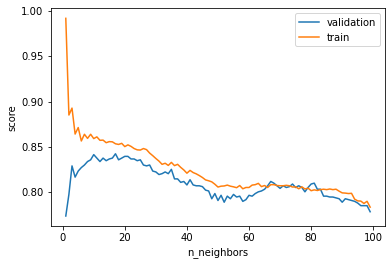

In [33]:
k = np.arange(1,100)
train_score,val_score = validation_curve(knn,X_train,y_train,'n_neighbors',k,cv=5)

plt.plot(k,val_score.mean(axis=1),label='validation')
plt.plot(k,train_score.mean(axis=1),label='train')

plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

<b>Cette courbe permet d'éviter les cas d'overfitting, c'est à dire quand on a un très bon score sur le training set et un score moins bon sur le validation set.
Mais il existe une fonction sklearn encore plus complète qui permet de déterminer les meilleurs paramètres : GridSearchCV

<H3>GridSearchCV

In [34]:
param_grid = {'n_neighbors' : np.arange(1,100),
              'metric':['euclidean','manhattan']}
grid = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [35]:
grid.best_score_,grid.best_params_

(0.854768740031898, {'metric': 'manhattan', 'n_neighbors': 17})

In [36]:
best_knn = grid.best_estimator_

In [37]:
best_knn.score(X_test,y_test)

0.8664122137404581

<b>Nous obtenons finalement un score de 86,66% sur nos données de test

<H3>Confusion Matrix

In [38]:
confusion_matrix(y_test,best_knn.predict(X_test))

array([[127,  19],
       [ 16, 100]], dtype=int64)

In [39]:
y_test.value_counts()

0    146
1    116
Name: Survived, dtype: int64

In [40]:
(19+16)/(127+19+16+100) + 0.8664122137404581 # Verification

1.0

<b>Sur nos 262 individus tests, 146 sont morts et 116 ont survécus. Le nombre d'erreur sur les non survivants est de 19 soit 13,01% d'erreurs et le nombre d'erreur sur les survivants est de 16 soit 13,79% soit un taux d'erreur global de 13,34% ce qui correspond bien avec notre score de 86,64% du modèle.

<h1>Methode de prédiction par Arbre de décision

In [41]:
clf = DecisionTreeClassifier(random_state=0)

In [42]:
X = df.drop(columns=['Survived','Age','Fare'])
Y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)

In [43]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(random_state=0)

In [44]:
clf.score(X_test,y_test)

0.8702290076335878

<h1>Logistic Regression

In [45]:
logreg = LogisticRegression(random_state=0)

In [46]:
X = df.drop(columns=['Survived','cat_age','cat_fare'])
Y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)

In [47]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [48]:
logreg.score(X_test,y_test)

0.8702290076335878

In [49]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,0,0.317647,1,0,0.014151,8,2
1,1,1,0.505882,1,0,0.139136,2,0
2,3,1,0.364706,0,0,0.015469,8,2
3,1,1,0.470588,1,0,0.103644,2,2
4,3,0,0.470588,0,0,0.015713,8,2
...,...,...,...,...,...,...,...,...
1304,3,0,0.388235,0,0,0.015713,8,2
1305,1,1,0.517647,0,0,0.212559,2,0
1306,3,0,0.511765,0,0,0.014151,8,2
1307,3,0,0.388235,0,0,0.015713,8,2


<H3>GridSearchCV

In [50]:
param_grid = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty':['l1', 'l2', 'elasticnet', 'none'],
              'max_iter':[1,3,5,10,15,20,25, 75, 100, 125, 150, 175, 200, 250]}
grid = GridSearchCV(LogisticRegression(),param_grid,cv=5)
grid.fit(X_train,y_train)

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selectio

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to conver

C:\Users\33638\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_select

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\Users\33638\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-t

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_select

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linea

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: 

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\33638\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.pena

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\Users\33638\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

C:\Users\33638\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_an

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The s

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver,

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (stat

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\l

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_sele

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The sc

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The sc

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_v

C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_sele

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The sc

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_v

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The sc

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_val

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The sc

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_val

C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\33638\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\33638\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The sc

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'max_iter': [1, 3, 5, 10, 15, 20, 25, 75, 100, 125,
                                      150, 175, 200, 250],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [51]:
grid.best_score_,grid.best_params_

(0.8566962861699704, {'max_iter': 5, 'penalty': 'l2', 'solver': 'sag'})

In [52]:
best_logreg = grid.best_estimator_

In [53]:
best_logreg.score(X_test,y_test)

0.8702290076335878

<H1>Random Forest

In [77]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
X = df.drop(columns=['Survived'])
Y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.8664122137404581

In [78]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
X = df.drop(columns=['Survived',"cat_age","cat_fare"])
Y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.8053435114503816

In [56]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
X = df.drop(columns=['Survived',"Age","Fare"])
Y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.8053435114503816

In [61]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'Embarked', 'cat_age', 'cat_fare'],
      dtype='object')

In [83]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
X = df[[ 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']]
Y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.8664122137404581

<H1>Fonction de prédiction de survie avec l'algorythme KNN

In [57]:
def survie_knn(Pclass,Sex,Age,SibSp,Parch,Fare=33,Cabin="U",Embarked="S"):
    x = np.array([Pclass,Sex,scaler_age.transform([[Age]])[0][0],SibSp,Parch,scaler_fare.transform([[Fare]])[0][0],transformer_cabin.transform([[Cabin]])[0],transformer_embarked.transform([[Embarked]])[0]]).reshape(1,8)
    print(best_knn.predict(x))
    print(best_knn.predict_proba(x))
    if best_knn.predict(x)==0:
        p = round(best_knn.predict_proba(x)[0][0]*100)
        print(f"Vous êtes mort ! (Probabilité de",p,"%)")
    if best_knn.predict(x)==1:
        p = round(best_knn.predict_proba(x)[0][1]*100)
        print("Vous avez survécu au naufrage du Titanic ! (Probabilité de",p,"%)")

In [58]:
survie_knn(1,0,26,0,0)

[0]
[[0.76470588 0.23529412]]
Vous êtes mort ! (Probabilité de 76 %)


C:\Users\33638\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<b>Même en première classe, je serais très probablement mort dans le naufrage du Titanic.

In [59]:
survie_knn(2,0,26,0,0)

[0]
[[0.94117647 0.05882353]]
Vous êtes mort ! (Probabilité de 94 %)


C:\Users\33638\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [60]:
survie_knn(3,0,26,0,0)

[0]
[[0.88235294 0.11764706]]
Vous êtes mort ! (Probabilité de 88 %)


C:\Users\33638\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<b>Element étonnant, il semblerais que j'ai plus de chance de mourir en deuxième classe qu'en troisième...